##Task 1

In [ ]:
#Download Train Images
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

#Download Train Labels
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

#Download Test Images
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz

#Download Test Labels
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2023-04-27 04:23:39--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-04-27 04:23:39 (88.5 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-04-27 04:23:39--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[=========

In [ ]:
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz

In [ ]:
!pip install idx2numpy
import idx2numpy

trainImagesF = 'train-images-idx3-ubyte'
trainLabelsF = 'train-labels-idx1-ubyte'
testImagesF = 't10k-images-idx3-ubyte'
testLabelsF = 't10k-labels-idx1-ubyte'

trainImages = idx2numpy.convert_from_file(trainImagesF)
trainLabels = idx2numpy.convert_from_file(trainLabelsF)
testImages = idx2numpy.convert_from_file(testImagesF)
testLabels = idx2numpy.convert_from_file(testLabelsF)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7918 sha256=2990e0bb06d40fd4c2947d0b2a947da4a0e0b75ef3c43076259235c54f290296
  Stored in directory: /root/.cache/pip/wheels/34/61/53/a6a64db5e907bdf792f401b5bfb922eabfe6686d08692167f3
Successfully built idx2numpy


In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow, cv2
import pandas as pd

print(trainImages.shape)
print(trainLabels[0:5])

input = np.reshape(trainImages, (trainImages.shape[0], trainImages.shape[1] * trainImages.shape[2]))
test_input = np.reshape(testImages, (testImages.shape[0], testImages.shape[1] * testImages.shape[2]))
print("Reshaped Input: ", input.shape)
print("Test Reshaped: ", test_input.shape)

(60000, 28, 28)
[5 0 4 1 9]
Reshaped Input:  (60000, 784)
Test Reshaped:  (10000, 784)


In [ ]:
#One Hot Encoding the Labels
def oneHotEncode(labels):
  numUniqueLabels = len(set(labels))
  output = []
  for y in labels:
    encode = [0 for _ in range(numUniqueLabels)]
    encode[y] = 1
    output.append(encode)

  output = np.array(output)
  print(output.shape)
  return numUniqueLabels, output

num_classes, Y_train = oneHotEncode(trainLabels)
Y_test = oneHotEncode(testLabels)[1]

(60000, 10)
(10000, 10)


##Linear Classifier & Task 2

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class Perceptron:

  def __init__(self, num_classes):
    self.w = None
    self.num_classes = num_classes
    np.random.seed(42)

  def model(self, x):
    #self.w.shape = num_classes x num_features, x.shape = Batch_Size x num_features, return shape = Batch_Size x num_classes
    z = np.matmul(self.w, x.T).T
    #print(z)
    return np.exp(z - np.max(z)) / np.exp(z - np.max(z)).sum()

  def loss(self, X, Y, W):

    Z = -np.matmul(X, W.T)
    N = X.shape[0]
    loss = (1/N) * (np.trace(np.matmul(X, W.T, Y) + np.sum(np.log(np.sum(np.exp(Z), axis=1)))))
    return loss

  def createBatches(self, data = None, batch_size = 1):
    if data is None:
      return None
    num_batches = data.shape[0] // batch_size
    np.random.shuffle(data)
    batches = []

    for i in range(num_batches):
      mini_batch = data[i * batch_size : (i + 1) * batch_size, :]
      batches.append(mini_batch)

    if data.shape[0] % batch_size != 0:
      remainderBatch = data[(i + 1) * batch_size: , :]
      batches.append(remainderBatch)

    return np.array(batches)

  def predict(self, inp):
        P = self.model(inp)
        return np.argmax(P, axis = 1)

  def fit(self, X, Y, epochs = 1, lr = 1, batch_size = 1, lambdaReg = 0.1):
    data = np.concatenate((X/255., Y), axis = 1)

    #num_classes x num_features shaped weight matrix
    self.w = np.zeros((self.num_classes, data.shape[1] - self.num_classes))
    accuracyList = []
    max_accuracy = 0
    chkptw = None
    lossList = []

    for epoch in range(epochs):
      mini_batches = self.createBatches(data, batch_size)
      stepLoss = 0
      for mini_batch in mini_batches:
        batch_x = mini_batch[:, :-self.num_classes]
        batch_y = mini_batch[:, -self.num_classes:]
        y_pred = self.model(batch_x)
        y_pred = y_pred > 0.5

        self.w = self.w + ((lr/batch_size) * np.matmul((batch_y - y_pred).T, batch_x)) - (2 * lambdaReg * self.w)

        stepLoss += self.loss(batch_x, batch_y, self.w)
      lossList.append(stepLoss / len(mini_batches))

      accuracy = accuracy_score(self.predict(test_input/255.), np.argmax(Y_test, axis = 1))
      accuracyList.append(accuracy)
      if accuracy > max_accuracy:
        max_accuracy = accuracy
        chkptw = self.w

    self.w = chkptw

    print("Maximum Accuracy:", max_accuracy)
    plt.plot(accuracyList, label = 'Accuracy')
    plt.plot(lossList, label = 'Loss')
    plt.legend()
    plt.show()

##Task 3

##Training takes more than 400 seconds for batch size of 1 and nearly 60 seconds for a batch size of 1000 for the same number of epochs. This shows that batch size is inversely proportional to the training time since weight updates are made at the end of every batch.



In [ ]:
import time

##Batch Size = 1

##Learning Rate: 0.0003

Maximum Accuracy: 0.6946


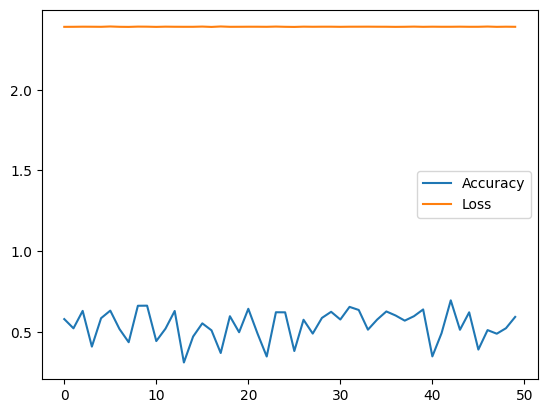

Time for training(Batch Size = 1): 377.8055100440979


In [ ]:
X_train = input
model_1 = Perceptron(num_classes=num_classes)
start = time.time()
model_1.fit(X_train, Y_train, epochs = 50, lr = 0.0003, batch_size = 1, lambdaReg = 0.001)
end = time.time()
print("Time for training(Batch Size = 1):", (end - start))

##Batch Size = 10

##Learning Rate : 0.0005

Maximum Accuracy: 0.7163


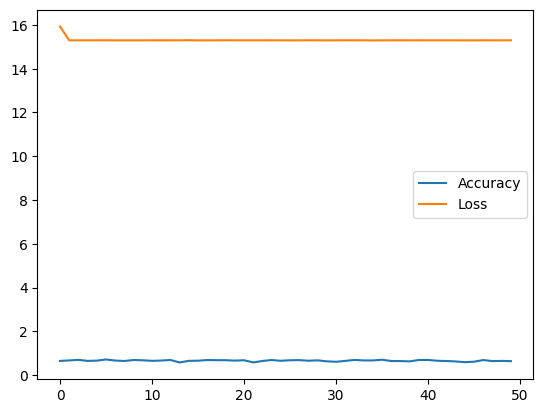

Time for training(Batch Size = 10): 69.81872200965881


In [ ]:
model_10 = Perceptron(num_classes=num_classes)
start = time.time()
model_10.fit(X_train, Y_train, epochs = 50, lr = 0.0005, batch_size = 10, lambdaReg = 0.001)
end = time.time()
print("Time for training(Batch Size = 10):", (end - start))

##Batch Size = 100
##Learning Rate: 0.005

Maximum Accuracy: 0.7164


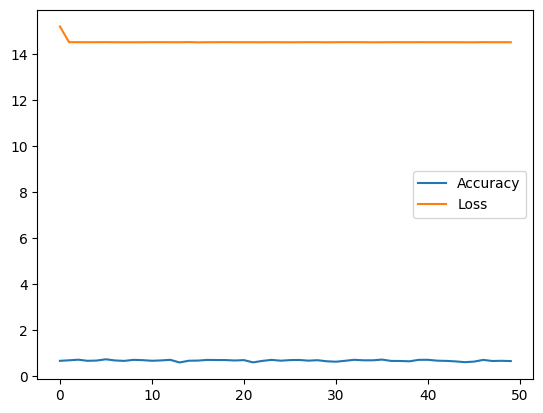

Time for training(Batch Size = 100): 55.3441104888916


In [ ]:
model_100 = Perceptron(num_classes=num_classes)
start = time.time()
model_100.fit(X_train, Y_train, epochs = 50, lr = 0.005, batch_size = 100, lambdaReg = 0.01)
end = time.time()
print("Time for training(Batch Size = 100):", (end - start))

##Batch Size = 1000
## Learning Rate: 0.01

Maximum Accuracy: 0.7176


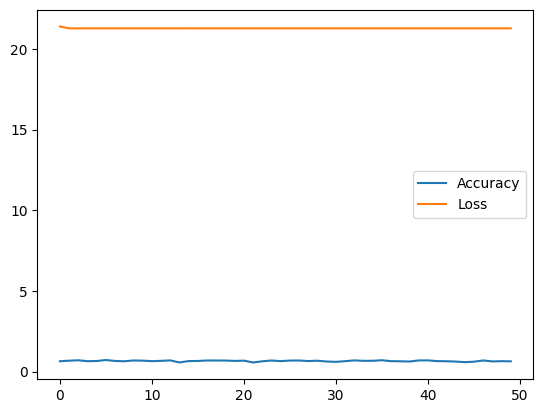

Time for training(Batch Size = 1000): 56.1794650554657


In [ ]:
model_1000 = Perceptron(num_classes=num_classes)
start = time.time()
model_1000.fit(X_train, Y_train, epochs = 50, lr = 0.01, batch_size = 1000, lambdaReg = 0.1)
end = time.time()
print("Time for training(Batch Size = 1000):", (end - start))

In [ ]:
cv2_imshow(testImages[0])
cv2_imshow(testImages[1])
cv2_imshow(testImages[2])
cv2_imshow(testImages[3])
cv2_imshow(testImages[4])
#print(np.argmax(Y_train[5:10], axis = 1))
print(model_1.predict(test_input[:5]/255.))
print(model_10.predict(test_input[:5]/255.))
print(model_100.predict(test_input[:5]/255.))
print(model_1000.predict(test_input[:5]/255.))

[7 6 1 0 4]
[7 6 1 0 4]
[7 6 1 0 4]
[7 6 1 0 4]


##Task 4
##Role of Batch Size:

As can be seen from the snippets above, for the larger batch sizes, the error is averaged or smoothened out, hence the weight adjustment is not erratic and the classification accuracy curve is smooth. For batch size = 1, each training example adjusts the weight vector and hence the accuracy fluctuates in a jagged fashion. The training time is affected by batch size greatly as can already be seen, larger the batch size, lower the training time.

##Task 5

## As dataset size increases, accuracy increases

Dataset Size: 100
Maximum Accuracy: 0.3446


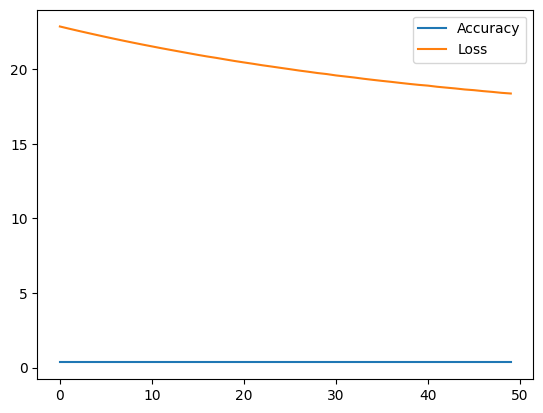


Dataset Size: 500
Maximum Accuracy: 0.5146


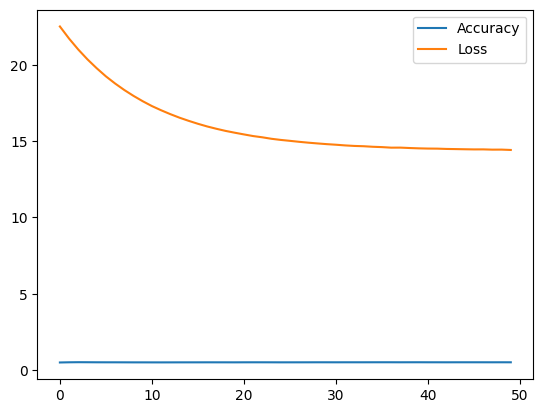


Dataset Size: 1000
Maximum Accuracy: 0.5411


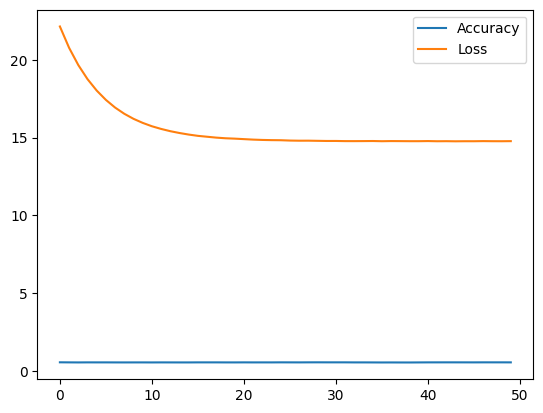


Dataset Size: 10000
Maximum Accuracy: 0.6997


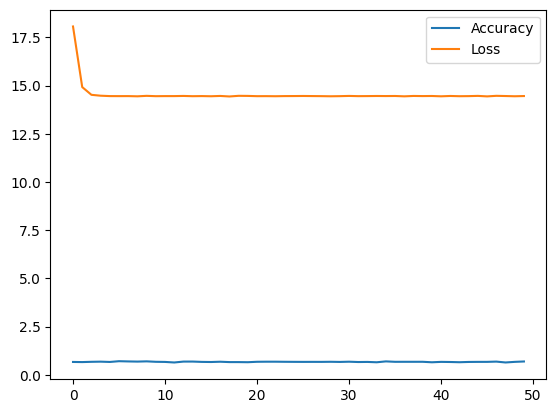

In [ ]:
N_Prime = [100, 500, 1000, 10000]
data = np.concatenate((X_train, Y_train), axis = 1)

for N in N_Prime:
  np.random.shuffle(data)
  curr_data_X = data[:N, :-num_classes]
  curr_data_Y = data[:N, -num_classes:]
  curr_model = Perceptron(num_classes = num_classes)
  print("Dataset Size:", N)
  curr_model.fit(curr_data_X, curr_data_Y, epochs = 50, lr = 0.005, batch_size = 100, lambdaReg = 0.01)
  print()
  data = data[N:, :]

##Task 6
## The accuracy and loss plots are consistent with my result of batch size 100.

Time taken for Tensorflow Training: 112.57628178596497
313/313 [==============================] - 0s 1ms/step
0.6751


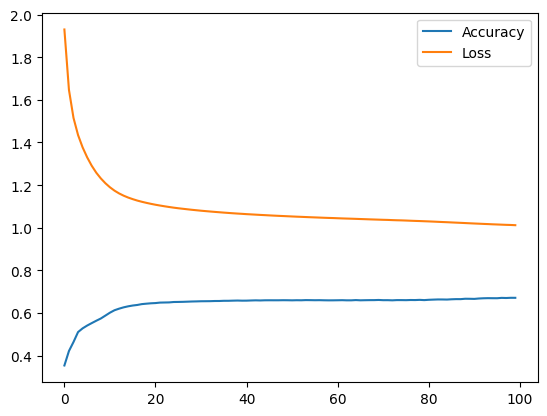

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import SGD
import tensorflow as tf
import keras

model = Sequential()
model.add(Dense(2, input_dim=784, activation='linear', kernel_initializer = 'zeros', kernel_regularizer=keras.regularizers.l2(0.01),  name='layer1'))
model.add(Dense(10, activation = 'softmax'))
opt = SGD(learning_rate=0.005)
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
start = time.time()
history = model.fit(input/255., Y_train, epochs=100, batch_size=100, verbose = False)
end = time.time()
print("Time taken for Tensorflow Training:", (end - start))
print(accuracy_score(np.argmax(model.predict(test_input/255.), axis = 1), testLabels))
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()
plt.show()